In [1]:
!pip install TensorFlow
!pip install Keras
!pip install pillow
!pip install NumPy
!pip install tqdm
!pip install jupyterlab


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
^C
Traceback (most recent call last):
  File "/Users/sushmey/Documents/Image Caption Generator/venv/bin/pip", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Users/sushmey/Documents/Image Caption Generator/venv/lib/python3.11/site-packages/pip/_internal/cli/main.py", line 79, in main
    return command.main(cmd_args)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sushmey/Documents/Image Caption Generator/venv/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 101, in main
    return self._main(args)
           ^^^^^^^^^^^^^^^^
  File "/Users/sushmey/Documents/Image Caption Generator/venv/lib/python3.11/site-packages

In [26]:
!pip install Keras


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [27]:
pip install graphviz


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
!pip install Keras-Preprocessing


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [29]:
pip install pandas


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install pydot-ng~=2.0.0


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Concatenate
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm.notebook import tqdm #to check loop progress
tqdm().pandas()

2024-05-20 21:49:58.805679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


0it [00:00, ?it/s]

In [3]:
# Load the document file into memory
def load_fp(filename):
    # Open file to read
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all images with their captions
def img_capt(filename):
    file = load_fp(filename)
    captions = file.split("\n")
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split("\t")
        # print(f"img {img} -- caption {caption}")
        if img[:-2] not in descriptions: # -2 because we are skipping the number at the end of the image name
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
      for i,img_caption in enumerate(caps):
        img_caption.replace("-"," ")
        descp = img_caption.split()
        #uppercase to lowercase
        descp = [wrd.lower() for wrd in descp]
        #remove punctuation from each token
        descp = [wrd.translate(table) for wrd in descp]
        #remove hanging 's and a
        descp = [wrd for wrd in descp if(len(wrd)>1)] # len of `s is 2 but ' is removed in punctuation step
        #remove words containing numbers with them
        descp = [wrd for wrd in descp if(wrd.isalpha())]
        #converting back to string
        img_caption = " ".join(descp)
        captions[img][i]= img_caption
        #print(f"image {img} caption  - {captions[img][i]}")
    return captions

def txt_vocab(descriptions):
    # To build vocab of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
        # for d in descriptions[key]:
        #     [vocab.update(d.split())]
        #     print(d.split())
    return vocab

#To save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
      for desc in desc_list:
        lines.append(key + "\t" + desc )
        data = "\n".join(lines)
        file = open(filename,"w")
        file.write(data)
        file.close()
# Set these path according to project folder in you system
dataset_text = "Flickr8k_text"
dataset_images = "Flicker8k_Dataset"
#to prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#map them into descriptions dictionary 
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = txt_clean(descriptions)
#to build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [4]:
# Set SSL 

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
def extract_features(dirc):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for pic in tqdm(os.listdir(dirc)):
                   file = dirc + "/" + pic
                   image = Image.open(file)
                   image = image.resize((299,299))
                   image = np.expand_dims(image, axis=0)
                   #image = preprocess_input(image)
                   image = image/127.5 # Image normalization 255/2 = 127.5
                   image = image - 1.0 # Converting it to between range -1 to 1
                   feature = model.predict(image)
                   features[pic] = feature
        return features

In [3]:
# # Run only once

# #2048 feature vector
# features = extract_features(dataset_images)
# dump(features, open("features.p","wb"))
# #to directly load the features from the pickle file.
# features = load(open("features.p","rb"))

In [31]:
#load the data
def load_photos(filename):
    file = load_fp(filename)
    photos = file.split("\n")[:-1]
    return photos
def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_fp(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<2: # To skip img desc pair with no desc since len of list will be just 1 then. But it should be <2  not <1
            continue
        image, image_caption = words[0], words[1:]
        if image in photos: 
            if image not in descriptions:
                descriptions[image] = []
            desc = f' {" ".join(image_caption)} '
            # desc = ' ' + " ".join(image_caption) + ' '
            # print(desc)
            descriptions[image].append(desc)
    # print(descriptions["1000268201_693b08cb0e.jpg"])            
    return descriptions
def load_features(photos):
    #loading all featuresq
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    print(features["3644142276_caed26029e.jpg"])
    return features
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

[[0.         0.         0.29844972 ... 0.08661041 0.00043197 0.        ]]


In [7]:
#convert dictionary to clear list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
       [all_desc.append(d) for d in descriptions[key]]
    # print(f"Length of all_desc {len(all_desc)}")    
    return all_desc
#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary
from tensorflow.keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
# print(tokenizer.word_index)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size) #The size of our vocabulary is 7577 words.
#calculate maximum length of descriptions to decide the model structure parameters.
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
max_length = max_length(descriptions)
print(max_length) #Max_length of description is 32

7577
32


In [8]:
seq = tokenizer.texts_to_sequences([' child in pink dress is climbing up set of stairs in an entry way '])[0]
x_1, x_2, y = list(), list(), list()
for i in range(1, len(seq)):
    # divide into input and output pair
    in_seq, out_seq = seq[:i], seq[i]
    # pad input sequence
    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
    # encode output sequence
    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
    # store
    x_1.append("feature")
    x_2.append(in_seq)
    y.append(out_seq)
x_1, x_2, y = np.array(x_1), np.array(x_2), np.array(y)
print(f"{x_1}\n\n{x_2}\n\n {y}")
print(x_1.shape, x_2.shape, y.shape)

['feature' 'feature' 'feature' 'feature' 'feature' 'feature' 'feature'
 'feature' 'feature' 'feature' 'feature' 'feature' 'feature']

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0   40]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   40    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   40    1   85]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
    40    1   85  167]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0   40
     1   85  167    4]
 [   0    0    0    0    0    0

In [33]:
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while True:
        print(len(descriptions))
        i=0
        for key, description_list in descriptions.items():
            print(f"{len(description_list)}")
            #retrieve photo features
            feature = features[key][0]
            print(feature)
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ((inp_image, inp_seq), op_word)
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    # move through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # divide one sequence into various X,y pairs
        for i in range(1, len(seq)):
            # divide into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)
        print(f"{desc} - {len(x_1)}  - {len(x_2)} - {len(y)}")
    return np.array(x_1), np.array(x_2), np.array(y)
#To check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, train_features, tokenizer, max_length))
print(a.shape, b.shape, c.shape)

#((47, 2048), (47, 32), (47, 7577))

6000
5
[0.         0.         0.06418177 ... 0.         0.         0.        ]
 child in pink dress is climbing up set of stairs in an entry way  - 13  - 13 - 13
 girl going into wooden building  - 17  - 17 - 17
 little girl climbing into wooden playhouse  - 22  - 22 - 22
 little girl climbing the stairs to her playhouse  - 29  - 29 - 29
 little girl in pink dress going into wooden cabin  - 37  - 37 - 37
(37, 2048) (37, 32) (37, 7577)


In [34]:
[a,b],c = next(data_generator(descriptions, train_features, tokenizer, max_length))

8092
5
[0.         0.         0.06418177 ... 0.         0.         0.        ]
child in pink dress is climbing up set of stairs in an entry way - 13  - 13 - 13
girl going into wooden building - 17  - 17 - 17
little girl climbing into wooden playhouse - 22  - 22 - 22
little girl climbing the stairs to her playhouse - 29  - 29 - 29
little girl in pink dress going into wooden cabin - 37  - 37 - 37


In [35]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = Concatenate()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [36]:
# train our model
# print('Dataset: ', len(train_imgs))
# print('Descriptions: train=', len(train_descriptions))
# print('Photos: train=', len(train_features))
# print('Vocabulary Size:', vocab_size)
# print('Description Length: ', max_length)
# model = define_model(vocab_size, max_length)
# print(f"model {model}")
# epochs = 10
# steps = len(train_descriptions)
# # creating a directory named models to save our models
# # os.mkdir("models")
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
#     #model.fit([x1,x2],y)
#     model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save(f"models/model_{i}.h5")

In [10]:
pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [79]:
np.set_printoptions(threshold=np.inf)

In [64]:
np.array(tokenizer.word_index)

array({'in': 1, 'the': 2, 'on': 3, 'is': 4, 'and': 5, 'dog': 6, 'with': 7, 'man': 8, 'of': 9, 'two': 10, 'white': 11, 'black': 12, 'boy': 13, 'are': 14, 'woman': 15, 'girl': 16, 'to': 17, 'wearing': 18, 'at': 19, 'people': 20, 'water': 21, 'brown': 22, 'young': 23, 'red': 24, 'an': 25, 'his': 26, 'blue': 27, 'dogs': 28, 'running': 29, 'through': 30, 'playing': 31, 'while': 32, 'down': 33, 'shirt': 34, 'ball': 35, 'standing': 36, 'little': 37, 'grass': 38, 'snow': 39, 'child': 40, 'person': 41, 'jumping': 42, 'over': 43, 'three': 44, 'sitting': 45, 'front': 46, 'field': 47, 'holding': 48, 'small': 49, 'yellow': 50, 'green': 51, 'group': 52, 'up': 53, 'by': 54, 'large': 55, 'one': 56, 'walking': 57, 'her': 58, 'men': 59, 'children': 60, 'air': 61, 'into': 62, 'near': 63, 'mouth': 64, 'beach': 65, 'jumps': 66, 'runs': 67, 'another': 68, 'for': 69, 'street': 70, 'from': 71, 'its': 72, 'riding': 73, 'stands': 74, 'bike': 75, 'girls': 76, 'as': 77, 'outside': 78, 'play': 79, 'rock': 80, 'oth

1/1 [==============================] - 1s 1s/step
start of large rock formation in the mountains with the mountains in the background on the mountains in the background in the background on mountains in the background in background in background in


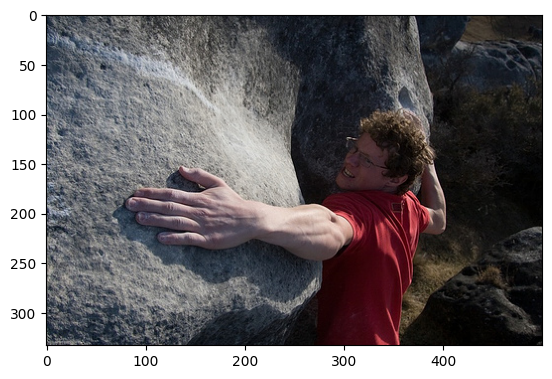

In [37]:
import numpy as np
from keras.models import load_model
from PIL import Image
from pickle import load
import matplotlib.pyplot as plt
import argparse
# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())
# img_path = args['image']
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
    # for 4 channels images, we need to convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        # print(pred.shape)
        # index = np.argmax(pred)
        #print(len(pred[0]))
        # print(pred[0][index])
        pred = np.argmax(pred)
        # print(f"max - {pred}")
        word = word_for_id(pred, tokenizer)
        # print(word)
        if word is None:
            break
        in_text += f" {word}"
        if word == 'end':
            break
    return in_text
max_length = 32
# img_path = "Flicker8k_Dataset/1028205764_7e8df9a2ea.jpg"
# img_path = "Flicker8k_Dataset/948196883_e190a483b1.jpg"
img_path = "Flicker8k_Dataset/950273886_88c324e663.jpg"
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print(description)
plt.imshow(img)

In [17]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [14]:
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


TypeError: load() missing required argument 'file' (pos 1)

In [1]:
!pip install tensorflow==2.15.0
# !pip install keras==2.15.0


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import tensorflow.keras.models

2024-05-18 15:40:51.478685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model = tf.keras.models.load_model('models/model_9.h5', compile=False)

ValueError: Could not interpret initializer identifier: {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None}